## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop

In [2]:
train_dir = '/opt/ml/input/data/train'

## 1. Model 정의

In [3]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 2. Train Dataset 정의

In [4]:
class TrainDataset(Dataset):
    def __init__(self,img_paths,labels,transform):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self,index):
        image = Image.open(self.img_paths[index])
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image,label

    def __len__(self):
        return len(self.img_paths)

## 3. DataLoader 정의

sample 이미지 살펴보고 transform 결정

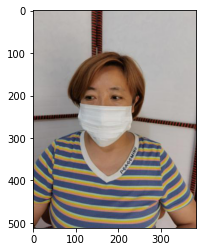

In [7]:
from matplotlib.pyplot import imshow
%matplotlib inline

image = Image.open(image_paths[5])
imshow(image)


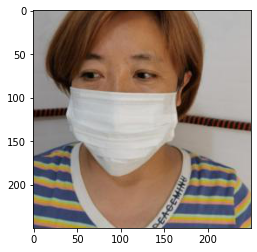

In [8]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    CenterCrop(250),
])
image2 = transform(image)
imshow(image2)

In [9]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_info = pd.read_csv(os.path.join(train_dir, 'train2.csv'))
image_paths = train_info['path']
labels = train_info['category']

transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    CenterCrop(250),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

train_dataset = TrainDataset(image_paths,labels,transform)
#val_dataset = 

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
#val_dataloader = 

## 4. Model 정의

In [12]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## 5. Train

In [ ]:
# 모델을 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=18).to(device)
model.train()

#hyperparam 정의
num_epoch = 5

#loss function, optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

#모델 학습
from tqdm import tqdm
for epoch in tqdm(range(num_epoch)):
    cur_loss=0.0
    for i,data in enumerate(train_dataloader):
        images,labels = data
        images, labels = images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        images.to(device)
        model_output = model(images)
        loss = criterion(model_output,labels)
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.item()
        if i%100==99:
            print('[%d,%5d] loss: %.3f'% (epoch+1,i+1,cur_loss/100))
            cur_loss=0.0
            
print('training finished')

In [30]:
torch.save(model,'models/model1.pth')